Imports
==============================================================================================

In [36]:
%matplotlib inline
import numpy as np
import pandas as pd
from keras.callbacks import TensorBoard, History
from keras.layers import Input, Dense, Dropout
from keras.utils import plot_model
from keras.models import Model
from pathlib import Path
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Configuration
==============================================================================================

In [37]:
# fix random seed for reproducibility
np.random.seed(13)

## net params
num_layers = 4
num_neurons = 300#500
batch_size = 100#500#1000
dropout_rate = 0
const_features = ['latitude', 'longitude', 'altitude', 'modules_per_string', 'strings_per_inverter', 'tilt',
                  'azimuth', 'albedo', 'Technology', 'BIPV', 'A_c', 'N_s', 'pdc0', 'gamma_pdc', 'SystemID']#15
dyn_features = ['Wind Direction_x', 'Wind Direction_y', 'Total Cloud Cover', 'Low Cloud Cover', 'Medium Cloud Cover',
                'High Cloud Cover', 'Wind Speed', 'Wind Gust', 'Total Precipitation',
                'Snow Fraction', 'Mean Sea Level Pressure', 'DIF - backwards', 'DNI - backwards', 'Shortwave Radiation',
                'Temperature', 'Relative Humidity', 'Hour_x', 'Hour_y', 'Month_x', 'Month_y']#20
#const_features = ['SystemID']
#dyn_features = ['DIF - backwards', 'DNI - backwards', 'Shortwave Radiation', 'Temperature', 'Relative Humidity', 'Hour_x', 'Hour_y', 'Month_x', 'Month_y']
target_features = ['power']
drop_features = ['power_pvlib']
act_fct = 'relu'
out_act = 'linear'
loss_fct = 'mae'
optim = 'adam'
metrics = []
history = History()
val_history = History()

## data params
filename = './data/full_data_5_systems.csv'
correlations = ['pearson']#'pearson', 'spearman', 'kendall']
timesteps = 5#24
shape = (len(const_features) + len(dyn_features) + timesteps * (len(dyn_features) + len(target_features)),)
forecast_horizon = 1

## training params
tensorboard = False
shuffle = True
epochs = 20
val_split = 1.0/10.0
dir = './test_results/'
if not os.path.exists(dir):
    os.makedirs(dir)

Helper Functions
==============================================================================================

In [38]:
def _draw_boxplot(data, offset, ax, edge_color, fill_color, mticks=False, num=1):
    pos = np.arange(num) + offset 
    bp = ax.boxplot(data, positions=pos, widths=0.3, patch_artist=True, whis='range', manage_xticks=mticks)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)
    return bp
    
def draw_boxplot(m_col, p_col, l_col, method, horizon, start=None, end=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    bp1 = _draw_boxplot(p_col[start:end] - m_col[start:end], -0.2, ax, 'red', 'tomato')
    bp2 = _draw_boxplot(l_col[start:end] - m_col[start:end], 0.2, ax, 'blue', 'cornflowerblue')
    ax.legend([bp1["boxes"][0], bp2["boxes"][0]], [horizon, method])
    name = dir + 'boxplot_' + horizon + '_vs_' + method
    if start:
        name += '_from' + start.replace(':', '-')
    if end:
        name += '_to' + end.replace(':', '-')
    fig.savefig(name + '.png', bbox_inches='tight')
    fig.show()
    
def draw_boxplot_monthly(m_col, p_col, l_col, method, horizon):
    fig, ax = plt.subplots(figsize=(18, 18))
    m0, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12 = '2016-02-01 00:00:00', '2016-03-01 00:00:00', '2016-04-01 00:00:00', '2016-05-01 00:00:00', '2016-06-01 00:00:00', '2016-07-01 00:00:00', '2016-08-01 00:00:00', '2016-09-01 00:00:00', '2016-10-01 00:00:00', '2016-11-01 00:00:00', '2016-12-01 00:00:00', '2017-01-01 00:00:00', '2017-02-01 00:00:00'
    preds = np.array([p_col[m0:m1] - m_col[m0:m1], p_col[m1:m2] - m_col[m1:m2],
                      p_col[m2:m3] - m_col[m2:m3], p_col[m3:m4] - m_col[m3:m4],
                      p_col[m4:m5] - m_col[m4:m5], p_col[m5:m6] - m_col[m5:m6],
                      p_col[m6:m7] - m_col[m6:m7], p_col[m7:m8] - m_col[m7:m8],
                      p_col[m8:m9] - m_col[m8:m9], p_col[m9:m10] - m_col[m9:m10],
                      p_col[m10:m11] - m_col[m10:m11], p_col[m11:m12] - m_col[m11:m12]])
    pvlibs = np.array([l_col[m0:m1] - m_col[m0:m1], l_col[m1:m2] - m_col[m1:m2],
                      l_col[m2:m3] - m_col[m2:m3], l_col[m3:m4] - m_col[m3:m4],
                      l_col[m4:m5] - m_col[m4:m5], l_col[m5:m6] - m_col[m5:m6],
                      l_col[m6:m7] - m_col[m6:m7], l_col[m7:m8] - m_col[m7:m8],
                      l_col[m8:m9] - m_col[m8:m9], l_col[m9:m10] - m_col[m9:m10],
                      l_col[m10:m11] - m_col[m10:m11], l_col[m11:m12] - m_col[m11:m12]])
    bp1 = _draw_boxplot(preds, -0.2, ax, 'red', 'tomato', True, len(preds))
    bp2 = _draw_boxplot(pvlibs, 0.2, ax, 'blue', 'cornflowerblue', True, len(pvlibs))
    ax.legend([bp1["boxes"][0], bp2["boxes"][0]], [horizon, method])
    ax.set_xticklabels(['february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'january'])
    fig.savefig(dir + 'boxplot_' + horizon + '_vs_' + method + '_monthly.png', bbox_inches='tight')
    fig.show()

def walkForwardDailyLoss(test_y, pred_y, method_y, method, horizon):
    j = int(len(test_y) / 24)
    d1 = np.array_split(test_y, j)
    d2 = np.array_split(pred_y, j)
    d3 = np.array_split(method_y, j)
    pred_error = pd.DataFrame([math.sqrt(mean_squared_error(d2[i], d1[i])) for i in range(len(d1))])
    method_error = pd.DataFrame([math.sqrt(mean_squared_error(d3[i], d1[i])) for i in range(len(d1))])
    print('mean ' + horizon + ' RMSE: ' + str(pred_error.mean()[0]))
    print('mean ' + method + ' forecast RMSE: ' + str(method_error.mean()[0]))
    
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.plot(pred_error)
    ax.plot(method_error)
    ax.set_title("Daily RMSE")
    ax.set_ylabel("RMSE in Watts")
    ax.set_yscale('linear')
    ax.legend([horizon + ' error', method + ' error'])
    fig.autofmt_xdate()
    plt.grid(True)
    fig.savefig(dir + horizon + '_dailyRMSE_full_' + '.png')
    fig.show()

def scatter_predictions(test_y, pred_y, horizon):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(test_y, pred_y)
    ax.plot([np.amin(test_y), np.amax(test_y)], [np.amin(pred_y), np.amax(pred_y)], 'k--', lw=3)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    fig.savefig(dir + 'scatter_' + horizon + '.png')
    fig.show()
    
def plot_timeseries(m_col, p_col, l_col, method, horizon, start=None, end=None):
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.plot(m_col[start:end])
    ax.plot(p_col[start:end])
    if l_col is not None:
        ax.plot(l_col[start:end])
    ax.set_title("pv power prediction")
    ax.set_ylabel("Power")
    ax.set_yscale('linear')
    ax.legend(['measured', horizon, method])
    fig.autofmt_xdate()
    plt.grid(True)
    name = dir + horizon + '_timeseries'
    if start:
        name += '_from' + start.replace(':', '-')
    if end:
        name += '_to' + end.replace(':', '-')
    if l_col is not None:
        name += '_with_' + method
    fig.savefig(name + '.png')
    fig.show()

def draw_histogram(p_col, m_col, horizon):
    fig, ax = plt.subplots(figsize=(12, 12)) 
    ax.hist(p_col - m_col, bins=200)
    fig.savefig(dir + horizon + '_histogram.png')
    fig.show()
    
def draw_history(history, test=False):
    hist = pd.DataFrame.from_dict(history.history)
    fig, ax = plt.subplots(figsize=(12, 12)) 
    ax.plot(hist)
    ax.legend(hist.columns.values)
    plt.grid(True)
    name = dir + 'loss_history'
    if test:
        name += '_test'
    fig.savefig(name + '.png')
    fig.show()

Build Model
==============================================================================================

(140,)


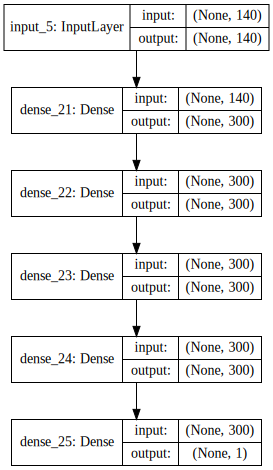

In [39]:
print(shape)
visible = Input(shape=shape)
pre = visible
for layer in range(0, num_layers):
    if dropout_rate > 0.0: 
        pre = Dropout(dropout_rate)(pre)
    pre = Dense(num_neurons, activation=act_fct)(pre)
output = Dense(len(target_features), activation=out_act)(pre)
model = Model(inputs=visible, outputs=output)
model.compile(loss=loss_fct, optimizer=optim, metrics=metrics)
plot_model(model, show_shapes=True, to_file=dir + 'model.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Data Preprocessing
==============================================================================================

In [40]:
pfname = dir + '/preprocessed_data_t-'+str(timesteps)+'_f'+str(shape[0])+'.csv'
prep = Path(pfname)
if prep.exists():
    print('Loading preprocessed dataset ...')
    pvlib = np.array_split(pd.read_csv(filename, skipinitialspace=True).set_index('time'), 5)[-1].power_pvlib
    dataset = pd.read_csv(pfname, skipinitialspace=True).set_index(['time', 'forecast_horizon', 'SystemID'])
else:
    print('Data preprocessing ...')
    df = pd.read_csv(filename, skipinitialspace=True).set_index('time')
    df = np.array_split(df, 5)[-1]##################################
    pvlib = df.power_pvlib
    dataset = df[const_features + dyn_features + target_features].copy()[:'2017-02-09 10:00:00']

    #separate system
    for i in range(1, timesteps + 1):
        for feature in dyn_features + target_features:
            sys.stdout.write("Shifting %i/%i %s                \r" % (i, timesteps, feature))
            sys.stdout.flush()
            dataset[feature + ' t-' + str(i)] = dataset.shift(i)[feature]
    print('Shifting done.                ')

    data = pd.DataFrame()
    for i in range(forecast_horizon):
        sys.stdout.write("Adding forecast horizon %i/%i                \r" % (i+1, forecast_horizon))
        sys.stdout.flush()
        d = dataset.copy()
        n = len(const_features) + len(const_features) + len(target_features) + 1
        d.iloc[:,n:] = d.iloc[:,n:].shift(i)
        d['forecast_horizon'] = i
        d['horizon'] = i
        data = data.append(d)
    print('Horizons done.                ')

    p = data[target_features]
    data = data.drop(target_features, axis=1)
    for f in target_features:
        data[f] = p[f]
    dataset = data[forecast_horizon:].dropna().reset_index().set_index(['time', 'forecast_horizon', 'SystemID'])

    sys.stdout.write("Writing to file ...\r")
    sys.stdout.flush()
    dataset.to_csv(pfname, encoding='utf-8')
    print('Writing done.                ')

    if correlations:
        sys.stdout.write('Computing correlations ...\r')
        sys.stdout.flush()
        for corr in correlations:
            sys.stdout.write("Computing %s correlation matrix                \r" % (corr))
            sys.stdout.flush()
            dataset.corr(method=corr).to_csv(dir + corr + '_correlations.csv', encoding='utf-8')
        print('Correlations done.                   ')

train, test = dataset[:('2015-10-12 06:00:00', 0, 4.0)], dataset[('2015-10-12 07:00:00', 0, 4.0):]
trainX, trainY = train.iloc[:,:-len(target_features)], train.iloc[:,-len(target_features):]
testX, testY = test.iloc[:,:-len(target_features)], test.iloc[:,-len(target_features):]
idx = testX.index.values

Loading preprocessed dataset ...


Training
==============================================================================================

In [41]:
if shuffle:
    df = pd.DataFrame(np.concatenate((trainX, trainY), axis=1))
    df = df.sample(frac=1).values
    y = df[:, -len(target_features):]
    X = df[:, :-len(target_features)]

if tensorboard:
    print('tensorboard activated')
    callbacks = [TensorBoard(log_dir='./tensorboard', histogram_freq=1, batch_size=batch_size, write_graph=True, write_grads=True, write_images=False), history]
else:
    callbacks = [history]

model.fit(X, y, batch_size, epochs=epochs, validation_split=val_split, callbacks=callbacks, verbose=1)

Train on 61367 samples, validate on 6819 samples
Epoch 1/20
61367/61367 [==============================] - 8s 133us/step - loss: 181.8116 - val_loss: 105.4450
Epoch 2/20
61367/61367 [==============================] - 8s 124us/step - loss: 100.6972 - val_loss: 106.4795
Epoch 3/20
61367/61367 [==============================] - 8s 126us/step - loss: 79.3526 - val_loss: 74.7832
Epoch 4/20
61367/61367 [==============================] - 8s 130us/step - loss: 69.0099 - val_loss: 67.9178
Epoch 5/20
61367/61367 [==============================] - 8s 132us/step - loss: 62.5964 - val_loss: 58.6935
Epoch 6/20
61367/61367 [==============================] - 8s 129us/step - loss: 59.6709 - val_loss: 70.2974
Epoch 7/20
61367/61367 [==============================] - 8s 133us/step - loss: 56.2078 - val_loss: 46.8519
Epoch 8/20
61367/61367 [==============================] - 8s 126us/step - loss: 58.7285 - val_loss: 48.3992
Epoch 9/20
61367/61367 [==============================] - 8s 125us/step - loss: 50.

Walk-Forward Validation
==============================================================================================

In [42]:
method = 'pvlib'

predictions = []
for i in range(len(testX)):
    sys.stdout.write("Walk-Forward Validation %i/%i\r" % (i, len(testX)))
    sys.stdout.flush()
    predictions.append(pd.DataFrame(model.predict(testX.iloc[i:i+1,:], 1, verbose=0)))
    window = i - 8766
    if window < 0:
        window = 0
    model.fit(testX.iloc[window:i+1,:], testY.iloc[window:i+1,:], batch_size=batch_size, epochs=50, verbose=0, callbacks=[val_history])
prediction = pd.concat(predictions)

Evaluation
==============================================================================================

mean +1h-prediction RMSE: 640.971147618975
mean pvlib forecast RMSE: 1333.7295076951114


C:\Users\he\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


+1h-prediction test RMSE: 741.549
pvlib forecast test RMSE: 1493.093
+1h-prediction nice day RMSE: 306.142
pvlib forecast nice day RMSE: 444.823


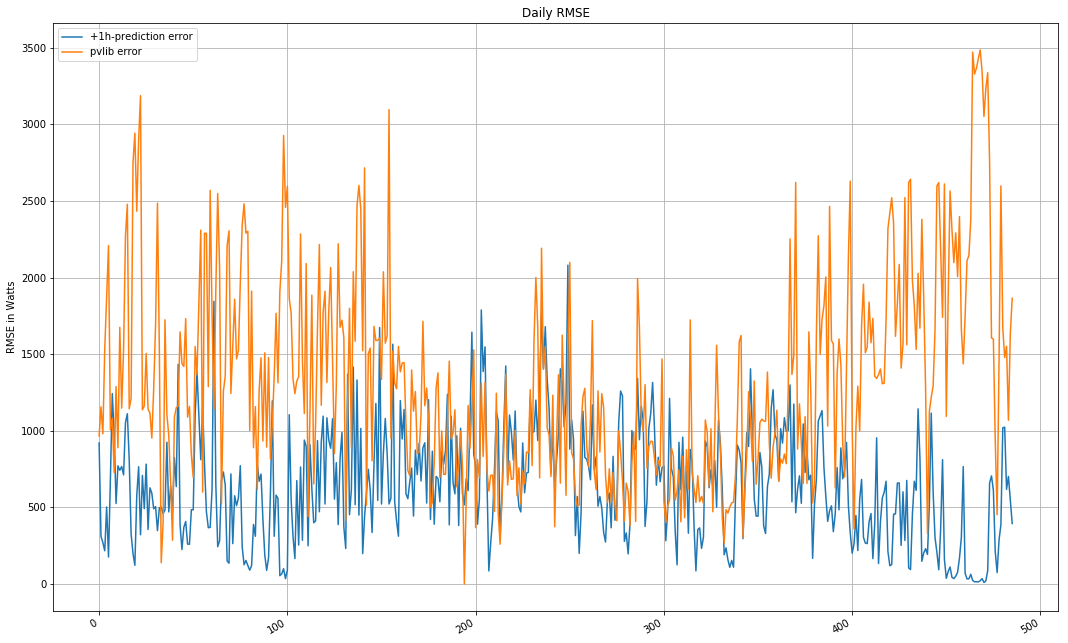

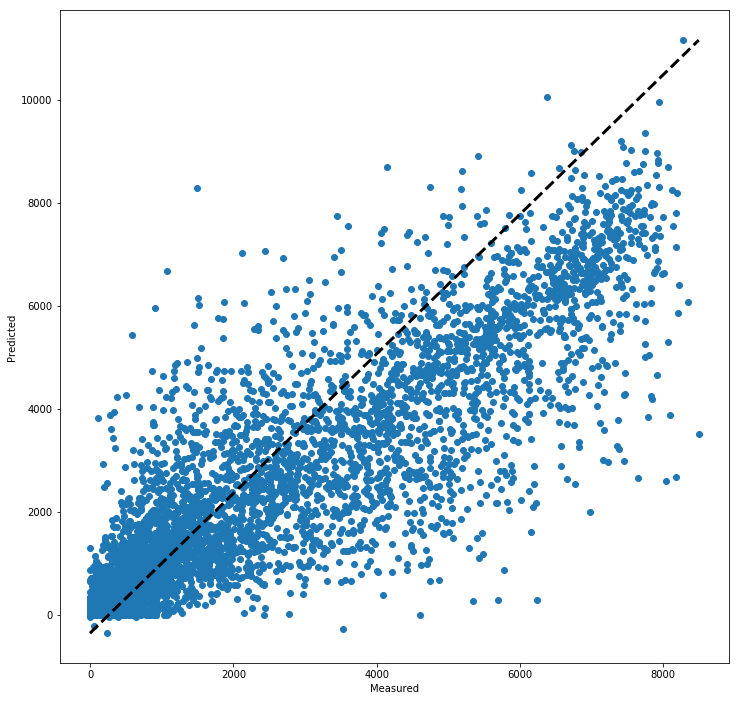

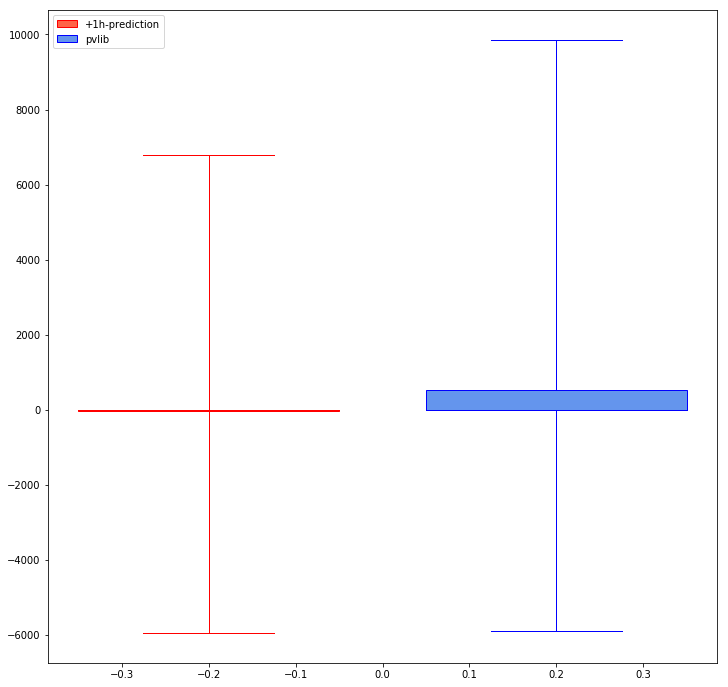

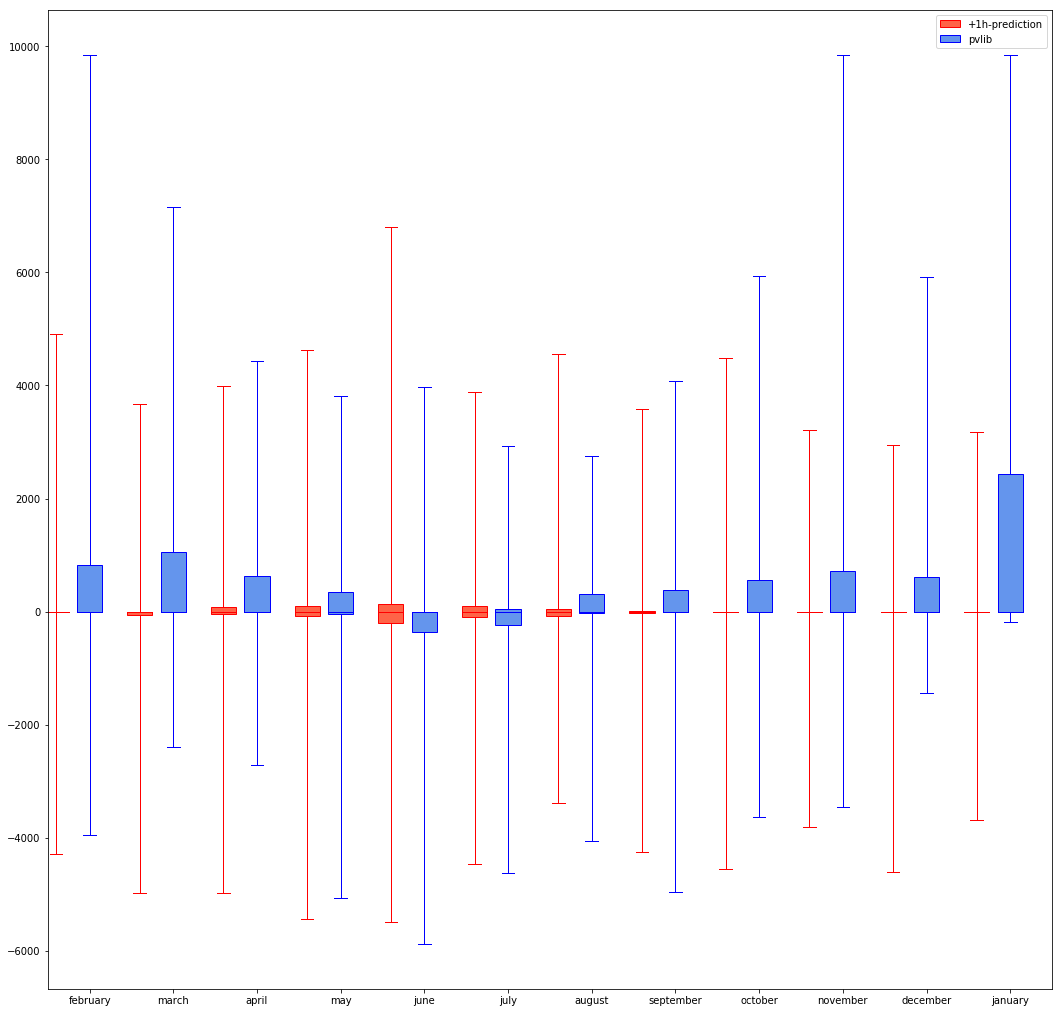

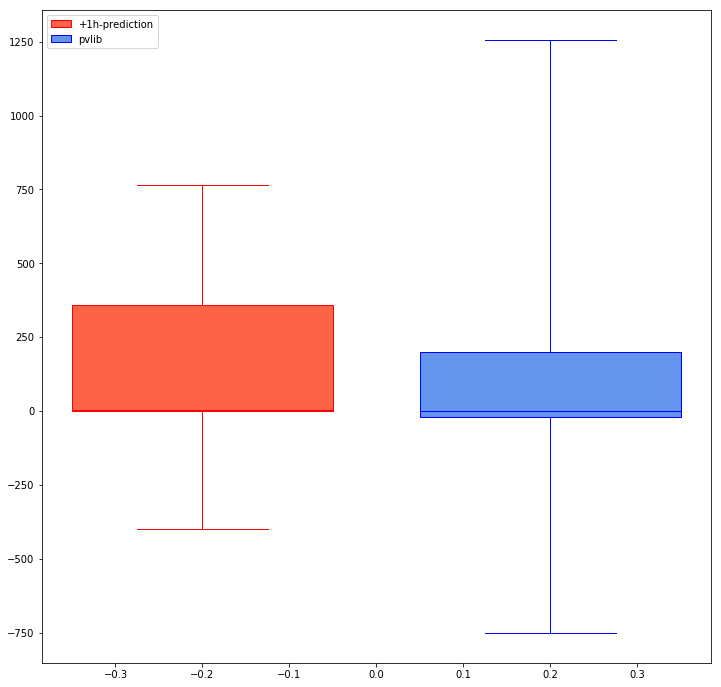

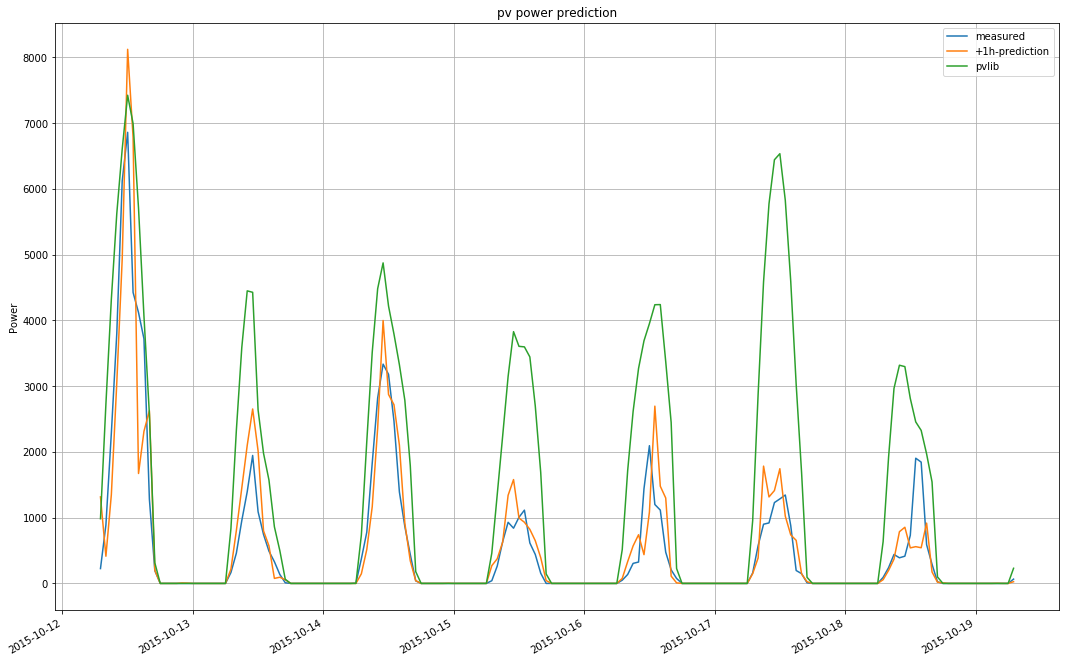

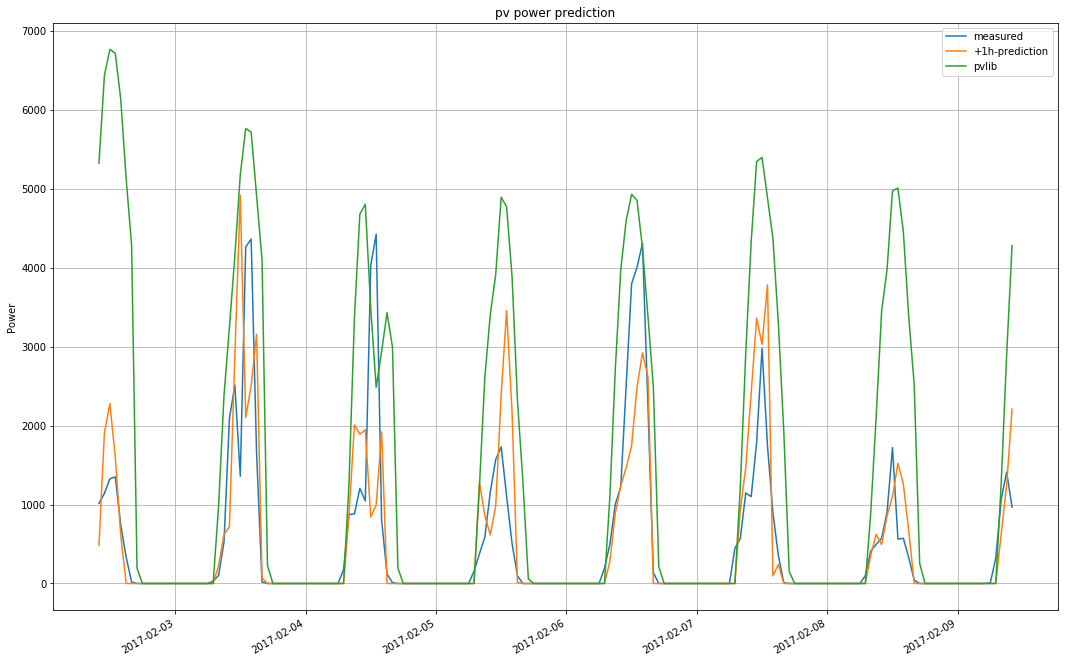

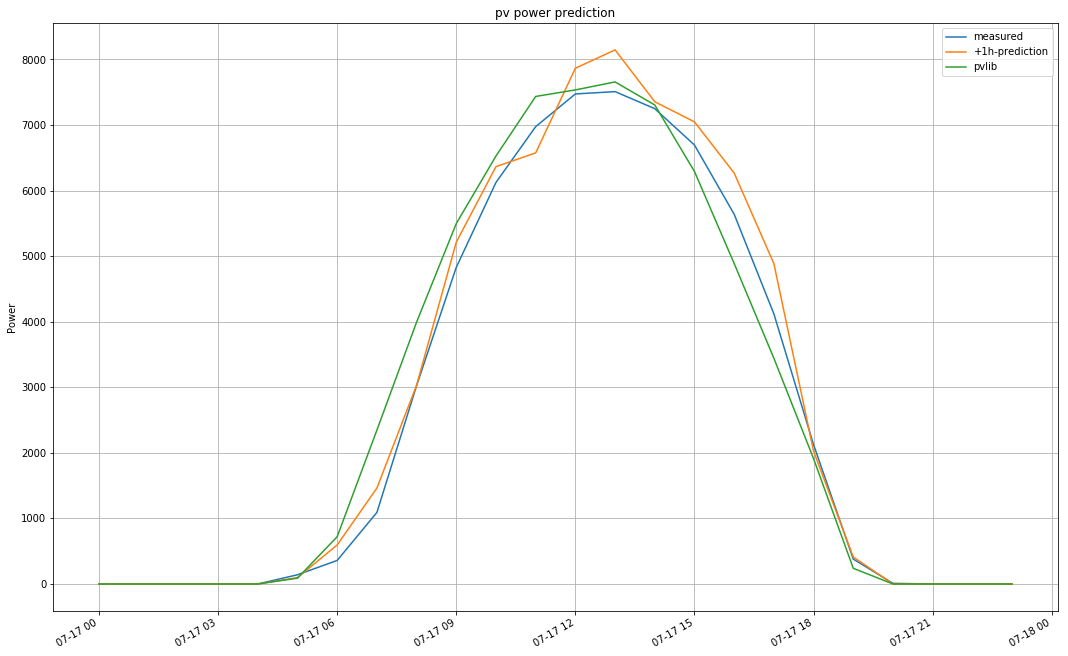

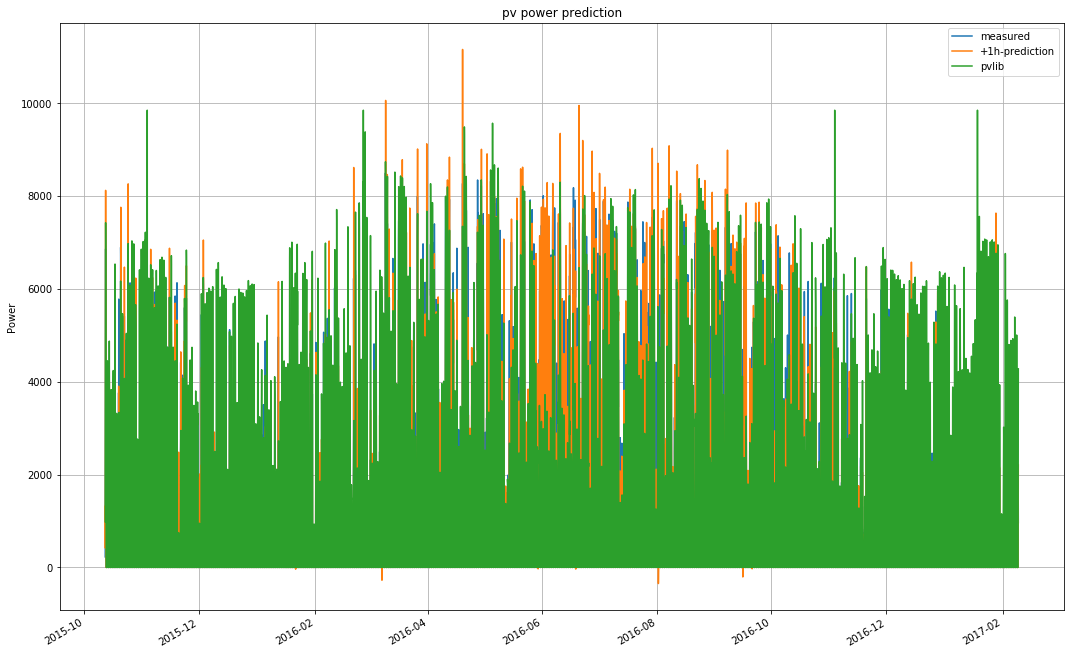

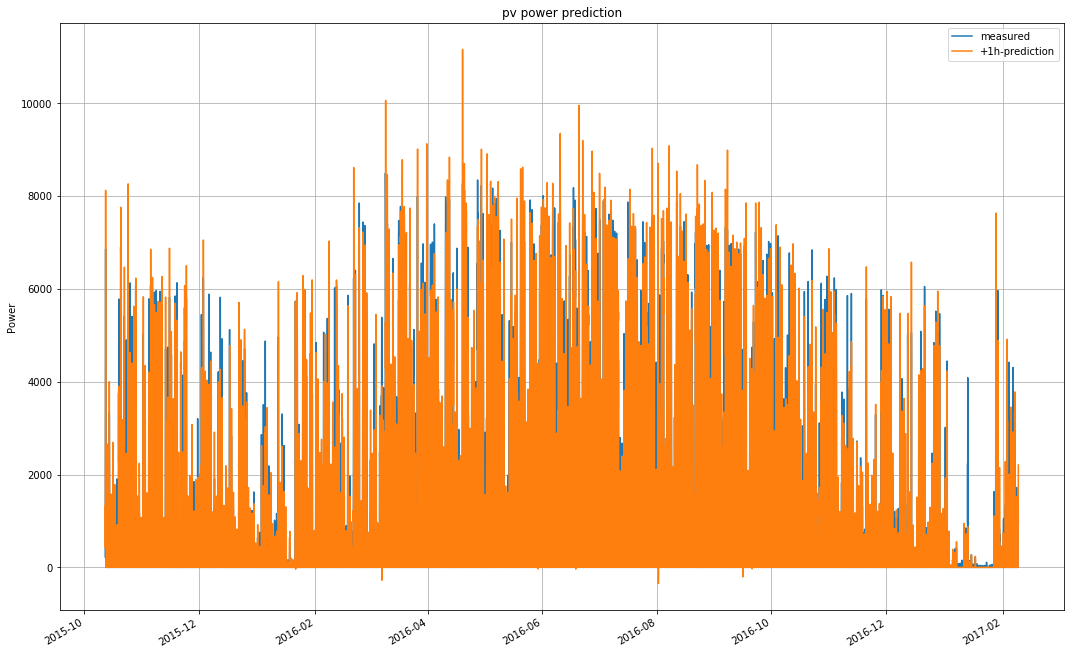

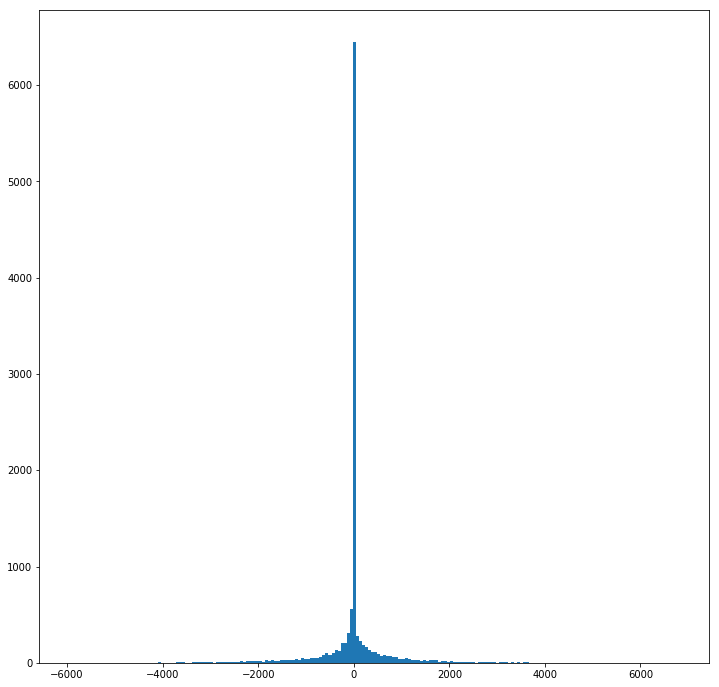

In [43]:
data = pd.DataFrame()
data['prediction'] = pd.DataFrame(np.array(prediction).reshape([len(prediction), len(target_features)])).iloc[:,0]
data['measured'] = pd.DataFrame(np.array(testY).reshape([len(testY), len(target_features)])).iloc[:,0]
data = data.set_index(pd.MultiIndex.from_tuples(idx)).unstack().unstack()
#data = data.drop(data.columns.values[forecast_horizon+1:], axis=1)
data['pvlib'] = pvlib['2015-10-12 07:00:00':'2017-02-09 10:00:00'].reindex(data.index)

tmp = pd.DataFrame()
for i in range(forecast_horizon):
    tmp['+' + str(i+1) + 'h-prediction'] = data[('prediction', 4.0, i)]
tmp[method] = data[method]
tmp['measured'] = data[('measured', 4.0, 0)]
data = tmp
data.index = pd.to_datetime(data.index)


m_col = data['measured']
l_col = data[method].dropna()

for horizon in range(1, forecast_horizon + 1):
    name = '+' + str(horizon) + 'h-prediction'
    p_col = data[name]

    walkForwardDailyLoss(m_col, p_col, l_col, method, name)
    scatter_predictions(m_col, p_col, name)

    print('%s test RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col, p_col))))
    print('%s test RMSE: %.3f' % (method + ' forecast', math.sqrt(mean_squared_error(m_col, l_col))))
    draw_boxplot(m_col, p_col, l_col, method, name)
    draw_boxplot_monthly(m_col, p_col, l_col, method, name)

    m1, m2 = '2016-07-17 00:00:00', '2016-07-17 23:00:00'
    print('%s nice day RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col[m1:m2], p_col[m1:m2]))))
    print('%s nice day RMSE: %.3f' % (method + ' forecast', math.sqrt(mean_squared_error(m_col[m1:m2], l_col[m1:m2]))))
    draw_boxplot(m_col, p_col, l_col, method, name, m1, m2)

    plot_timeseries(m_col, p_col, l_col, method, name, end='2015-10-19 07:00:00')
    plot_timeseries(m_col, p_col, l_col, method, name, start='2017-02-02 10:00:00')
    plot_timeseries(m_col, p_col, l_col, method, name, start=m1, end=m2)
    plot_timeseries(m_col, p_col, l_col, method, name)
    plot_timeseries(m_col, p_col, None, method, name)

    draw_histogram(p_col, m_col, name)

C:\Users\he\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


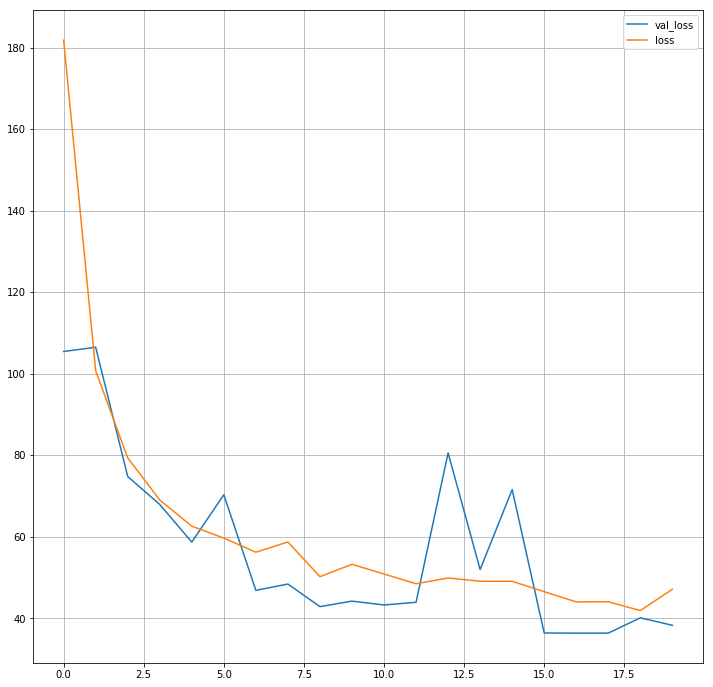

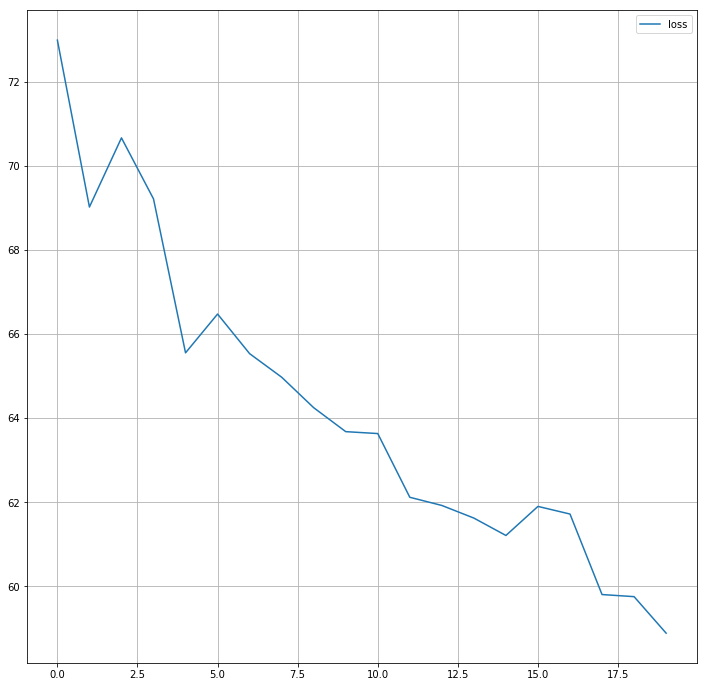

In [44]:
draw_history(history)
draw_history(val_history, True)

In [45]:
print(data.describe())
print(data.corr(method='pearson'))
print(data.corr(method='spearman'))
print(data.corr(method='kendall'))
data.to_csv(dir + 'predictions.csv', encoding='utf-8')

       +1h-prediction         pvlib      measured
count    11668.000000  11668.000000  11668.000000
mean      1049.173340   1549.927821   1065.316709
std       1897.253784   2226.069714   1924.789037
min       -349.100159      0.000000      0.000000
25%          0.000070      0.000000      0.000000
50%          0.005009      0.000000      0.000000
75%       1239.209534   2847.263861   1132.324223
max      11158.296875   9849.600000   8494.140630
                +1h-prediction     pvlib  measured
+1h-prediction        1.000000  0.779354  0.924841
pvlib                 0.779354  1.000000  0.777829
measured              0.924841  0.777829  1.000000
                +1h-prediction     pvlib  measured
+1h-prediction        1.000000  0.791381  0.845628
pvlib                 0.791381  1.000000  0.904175
measured              0.845628  0.904175  1.000000
                +1h-prediction     pvlib  measured
+1h-prediction        1.000000  0.628380  0.700854
pvlib                 0.628380  1.000000